In [6]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast,
                   linear_scale_forward, log_scale_forward, UniformPrior, beta_tuning_param_function)
import multiprocessing
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [7]:
# Set up prior distribution
prior_dict = {'EI_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'EE_gscale': {'bounds': (-2, 1), 'rescale_function': log_scale_forward},
              'II_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'IE_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'EI_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'EE_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'II_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'IE_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'L2e_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2i_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5e_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5i_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2e_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2i_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5e_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5i_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              }

prior = UniformPrior(parameters=list(prior_dict.keys()))

In [28]:
# Instiatiate network and collect connectivity data

# hnn_core_root = op.dirname(hnn_core.__file__)
# params_fname = op.join(hnn_core_root, 'param', 'default.json')
# params = read_params(params_fname)
# params.update({'N_pyr_x': 3, 'N_pyr_y': 3})

net = calcium_model()

# Extract all E-I connection types
E_gids = np.concatenate([net.gid_ranges['L2_pyramidal'], net.gid_ranges['L5_pyramidal']]).tolist()
I_gids = np.concatenate([net.gid_ranges['L2_basket'], net.gid_ranges['L5_basket']]).tolist()

EI_connections = pick_connection(net, src_gids=E_gids, target_gids=I_gids)
EE_connections = pick_connection(net, src_gids=E_gids, target_gids=E_gids)
II_connections = pick_connection(net, src_gids=I_gids, target_gids=I_gids)
IE_connections = pick_connection(net, src_gids=I_gids, target_gids=E_gids)

# Store in dictionary to be added to theta_dict
theta_extra = {'EI_connections': EI_connections, 'EE_connections': EE_connections, 
               'II_connections': II_connections, 'IE_connections': IE_connections,
               'lamtha': 4.0}
theta_extra['sample_idx'] =  0

# Update network parameters
thetai = torch.tensor(np.repeat(0.5, len(prior_dict)))
theta_dict = {param_name: param_dict['rescale_function'](thetai[param_idx].numpy(), param_dict['bounds']) for 
                param_idx, (param_name, param_dict) in enumerate(prior_dict.items())}

theta_dict['theta_extra'] = theta_extra

beta_tuning_param_function(net, theta_dict, rate=10)

In [39]:
dataset_type = 'connected'
dataset_indices = [0]

model_architecture = {'L5_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L2_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L5_basket': {'hidden_dim': 8, 'n_layers': 2},
                      'L2_basket': {'hidden_dim': 8, 'n_layers': 2}}

model_dict, dataset_dict = dict(), dict()
for cell_type in net.cell_types:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    model_dict[cell_type] = utils.model_celltype_lstm(
        input_size=input_size, output_size=output_size, device='cpu', **model_architecture[cell_type])
    model_dict[cell_type].load_state_dict(torch.load(f'{dataset_type}_models/{cell_type}_{dataset_type}_model.pt'))

In [34]:
#LSTM/GRU architecture for decoding
class model_network(nn.Module):
    def __init__(self, net, model_dict, dataset_dict, device='cuda:0', bidirectional=False):
        super(model_network, self).__init__()
        self.net = net
        self.model_dict = model_dict
        self.kernel_size = model_dict['L5_pyramidal'].kernel_size
        self.dataset_dict = dataset_dict

        self.device = device


        self.connectivity_dict = self.init_weight_matrix()


        self.threshold = net.threshold
        self.soma_idx = soma_idx  # index of soma compartment


        weight_matrix =  self.init_weight_matrix().detach().requires_grad_(True)
        # weight_matrix = torch.zeros((self.n_cells, self.L5Pyr_model.input_size, self.n_cells)).float().to(self.device)
    
        self.weight_matrix = nn.Parameter(weight_matrix).detach().to(self.device).requires_grad_(True)

    def forward(self, input_spikes_dict):
        hidden_dict = dict()
        for cell_type in self.net.cell_types:
            hidden_dict[cell_type] = self.model_dict[cell_type].init_hidden(input_spikes_dict[cell_type].size(0))
        
        pred_y_dict = {cell_type: list() for cell_type in self.net.cell_types}
        for time_idx in range(self.kernel_size, input_spikes_dict['L5_pyramidal'].size(1)-1):
            for cell_type, model in self.model_dict.items():
                batch_x = input_spikes_dict[cell_type][:, time_idx-self.L5Pyr_model.kernel_size:time_idx, :].to(self.device)

                out, hidden = self.L5Pyr_model(batch_x, hidden)
                pred_y.append(out[:,-1, self.soma_idx])

                if time_idx > self.L5Pyr_model.kernel_size:
                    spike_mask = ((pred_y[-1][:] > self.threshold) & (pred_y[-2][:] < self.threshold))
                
                    input_spikes_dict[cell_type][:, time_idx+1, :] += torch.matmul(self.weight_matrix.clamp(0, 10), spike_mask.float())

        pred_y = torch.stack(pred_y)
        return pred_y

    def init_weight_matrix(self):


 

In [47]:
connectivity_dict = dict()
for target_type in net.cell_types:
    target_gids = net.gid_ranges[target_type]

    connectivity_dict[target_type] = torch.zeros((len(net.gid_ranges[target_type]), input_size, net._n_cells)).float()

for conn in net.connectivity:
    if conn['target_type'] in net.cell_types:
        target_gids = net.gid_ranges[conn['target_type']]
        source_gids = net.gid_ranges[conn['src_type']]


In [48]:
class Network_Data:
    def __init__(self, net, soma_filter=False):
        self.net = net
        self.neuron_data_dict = dict()
        self.input_spike_dict = dict()
        
        self.connectivity_dict = dict()
        for cell_type, gid_list in net.gid_ranges.items():
            target_gids = net.gid_ranges[target_type]

            if cell_type in net.cell_types:
                connectivity_dict[target_type] = torch.zeros((len(net.gid_ranges[target_type]), input_size, net._n_cells)).float()

            for gid in gid_list:
                self.neuron_data_dict[gid] = SingleNeuron_Data(net, gid, soma_filter=soma_filter)

                # Initialize blank arrays for spikes recieved by each cell
                if cell_type in net.cell_types:
                    self.input_spike_dict[gid] = np.zeros(self.neuron_data_dict[gid].isec_array.shape)

        self.delay_matrix = torch.zeros((net._n_cells, net._n_cells)).float()
        for conn in net.connectivity:
            for src_gid, target_gid_list in conn['gid_pairs'].items():
                src_type = conn['src_type']

                # Positions assigned based on gid in real network
                src_pos_list = list(net.pos_dict[src_type])

                # Proximal/distal drives
                if src_type in net.cell_types:
                    src_pos = src_pos_list[src_gid - list(net.gid_ranges[src_type])[0]]
                else:
                    src_pos = src_pos_list[0]

                # Loop through all target gids and append spikes to appropriate array
                # **TODO** - need to add delay calculation
                for target_gid in target_gid_list:
                    conn_spikes = self.neuron_data_dict[src_gid].spikes_binned

                    target_type = conn['target_type']
                    receptor = conn['receptor']
                    loc = conn['loc']
                    # Positions assigned based on gid in real network
                    target_pos_list = list(net.pos_dict[target_type])
                    if target_type in net.cell_types:
                        target_pos = target_pos_list[target_gid - list(net.gid_ranges[target_type])[0]]
                    else:
                        target_pos = target_pos_list[0]

                    # Get distance dependent weight/delay for connection
                    weight, delay = _get_gaussian_connection(
                        src_pos, target_pos, conn['nc_dict'], inplane_distance=net._inplane_distance)

                    # Add delay to delay matrix
                    self.delay_matrix[src_gid, target_gid] = delay

                    conn_spikes *= weight

                    if loc in net.cell_types[target_type].sect_loc:
                        sect_loc = net.cell_types[target_type].sect_loc[loc]
                    else:
                        sect_loc = [loc]
                        assert loc in net.cell_types[target_type].sections

                    for sec in sect_loc:
                        input_spike_name = f'{sec}_{receptor}'
                        input_spike_idx = self.neuron_data_dict[target_gid].isec_name_lookup[input_spike_name]
                        self.input_spike_dict[target_gid][input_spike_idx, :] += conn_spikes

In [54]:
net_data = net.copy()
_ = simulate_dipole(net_data, dt=0.5, tstop=1, record_vsec='all', record_isec='all', record_dcell=True)
network_data = Network_Data(net_data, soma_filter=True)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...


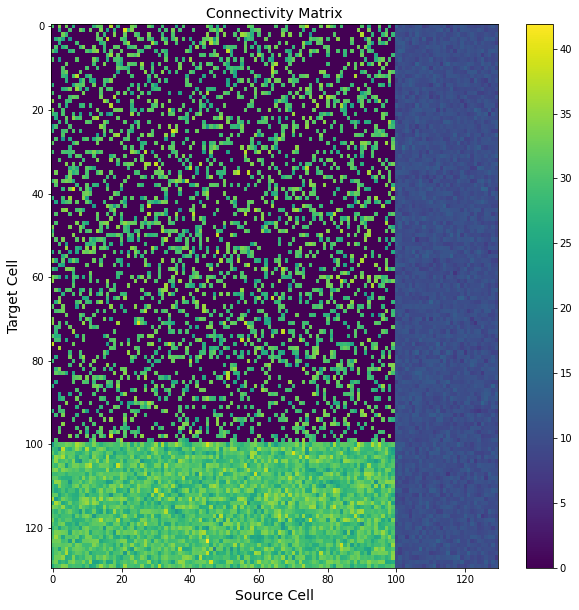

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(model.weight_matrix.detach().cpu().numpy().sum(axis=1), aspect='auto')
plt.title('Connectivity Matrix', fontsize=14)
plt.xlabel('Source Cell', fontsize=14)
plt.ylabel('Target Cell', fontsize=14)
plt.colorbar()

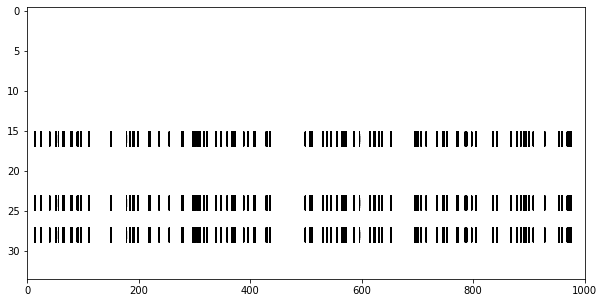

In [22]:
plt.figure(figsize=(10, 5))
plt.imshow(model.init_input_spikes()[model.drive_target_gids[0],:,:].T, aspect='auto', cmap='gray_r', vmin=0, vmax=0.0005)

In [23]:
# weight_tensor = torch.from_numpy(weight_matrix).clone().detach().to(device).requires_grad_(True)
# weight_param = nn.ParameterList([weight_matrix.clone()]).to(device)

lr = 1
weight_decay = 0

# Create Gradient mask
# gradient_mask = torch.zeros(model.weight_matrix.size()).to(device)
# gradient_mask[model.weight_matrix > 0] = 1.0
# model.weight_matrix.register_hook(lambda grad: grad.mul_(gradient_mask))

optimizer = torch.optim.Adam([model.weight_matrix], lr=lr, weight_decay=weight_decay)


In [62]:
print_freq = 10

max_epochs = 1000

input_spikes_init = model.init_input_spikes(n_samples=1000)
losses = list()
for epoch in range(max_epochs):
    # L5pyr_model.train()
    model.train()
    optimizer.zero_grad()
    input_spikes = input_spikes_init.clone().to(device).requires_grad_(False)

    pred_y = model(input_spikes)

    avg_soma = torch.mean(pred_y, axis=1)
    out_fft = torch.fft.rfft(avg_soma).abs()
    freq = torch.fft.rfftfreq(pred_y.size(0), dt / 1e3)


    power = torch.sum(out_fft[torch.logical_and(freq > 25, freq < 30)])
    total_power = torch.sum(out_fft[torch.logical_and(freq > 1, freq < 100)])

    relative_power = - (power / total_power)
    # relative_power = - power
    losses.append(relative_power.item())

    relative_power.backward()
    optimizer.step()

    #Print Loss Scores
    if (epoch+1)%print_freq == 0:
        print('')
        print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
        print('Relative Power: {:.4f}'.format(-relative_power))

    else:
        print('*', end='')


RuntimeError: CUDA out of memory. Tried to allocate 42.00 MiB (GPU 0; 5.78 GiB total capacity; 4.34 GiB already allocated; 66.31 MiB free; 4.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

(0.0, 100.0)

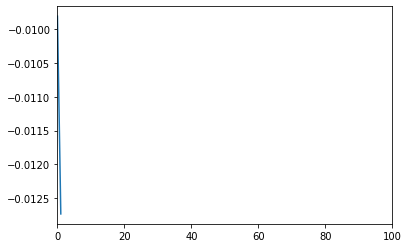

In [25]:
plt.plot(losses)
plt.xlim(0,100)

(1.0, 100.0)

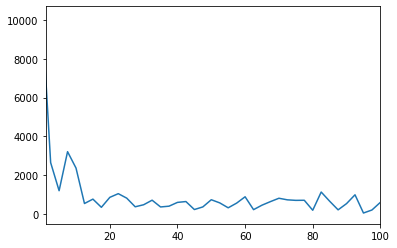

In [26]:
plt.plot(freq.detach().cpu().numpy(), out_fft.detach().cpu().numpy())
plt.xlim(1, 100)

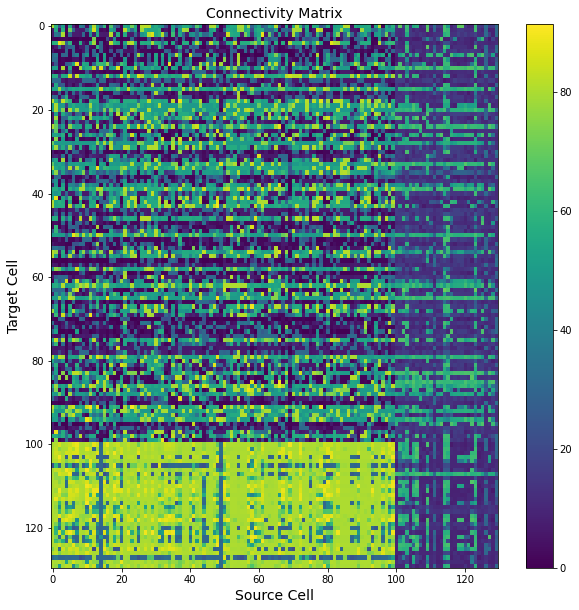

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(model.weight_matrix.detach().clamp(0,10).cpu().numpy().sum(axis=1), aspect='auto')
plt.title('Connectivity Matrix', fontsize=14)
plt.xlabel('Source Cell', fontsize=14)
plt.ylabel('Target Cell', fontsize=14)
plt.colorbar()

In [53]:
with torch.no_grad():
    model.eval()
    input_spikes = model.init_input_spikes(n_samples=2000).to(device).requires_grad_(False)
    pred_y = model(input_spikes)
pred_y_np = pred_y.unsqueeze(2).detach().cpu().numpy()

    
    

Text(0.5, 0, 'Time (ms)')

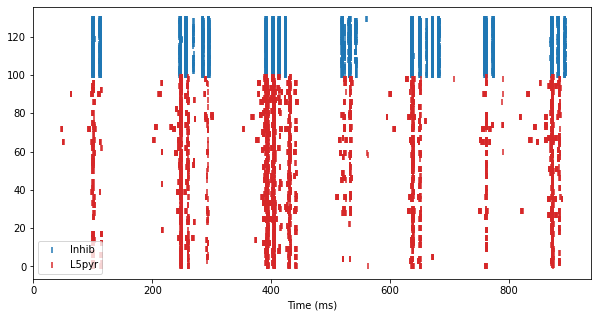

In [54]:
cell_spikes = pred_y_np > 50.0
cell_spike_indices = np.where(cell_spikes > 0)
L5pyr_mask, inhib_mask = np.in1d(cell_spike_indices[1], model.L5Pyr_gids), np.in1d(cell_spike_indices[1], model.inhib_gids)
L5pyr_spikes = (cell_spike_indices[1][L5pyr_mask], cell_spike_indices[0][L5pyr_mask])
inhib_spikes = (cell_spike_indices[1][inhib_mask], cell_spike_indices[0][inhib_mask])

plt.figure(figsize=(10, 5))
plt.scatter(inhib_spikes[1] * dt, inhib_spikes[0], c='C0', marker='|', label='Inhib')
plt.scatter(L5pyr_spikes[1] * dt, L5pyr_spikes[0], c='C3', marker='|', label='L5pyr')
plt.xlim(0, None)
plt.legend()
plt.xlabel('Time (ms)')

In [55]:
pred_y_np.shape

(1800, 130, 1)

In [56]:
output_size=1

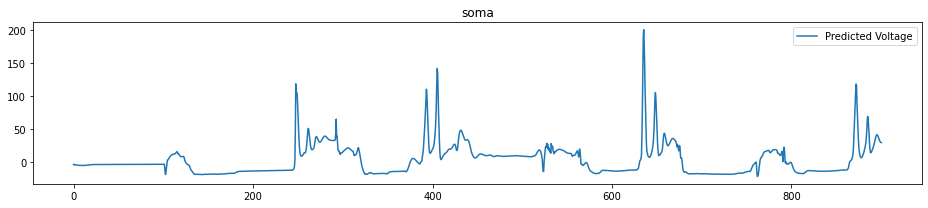

In [57]:
# output_size = len(training_set.datasets[0].vsec_names)
tvec = np.linspace(0, pred_y_np.shape[0] * dt, pred_y_np.shape[0])
plt.figure(figsize=(13, 3 * output_size))

for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(tvec, pred_y_np[:, 3, idx], color=f'C{idx}', label='Predicted Voltage')
    # plt.xlim(2000, 4000)
    plt.title(training_set.datasets[0].vsec_names[idx])
    # plt.ylim(-0.5,1.8)
plt.legend()
plt.tight_layout()

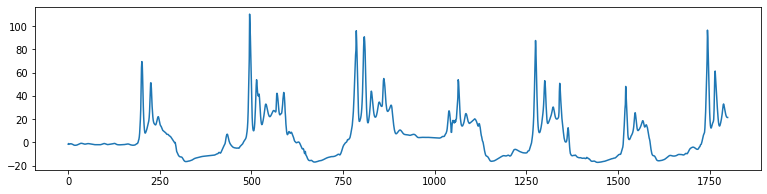

In [58]:
plt.figure(figsize=(13, 3))
plt.plot(np.mean(pred_y_np[:, :,-1], axis=1))

In [59]:
avg_soma = torch.mean(pred_y, axis=1)
out_fft = torch.fft.rfft(avg_soma).abs()
freq = torch.fft.rfftfreq(pred_y.size(0), dt / 1e3)

(1.0, 100.0)

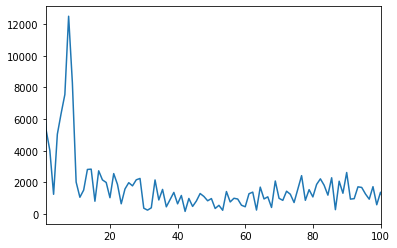

In [61]:
plt.plot(freq.detach().cpu().numpy(), out_fft.detach().cpu().numpy())
plt.xlim(1, 100)

In [ ]:
# def random_weight_matrix(n_cells, n_sec, sec_indices, src_size=100, target_size=100,
#                          src_range=None, target_range=None, max_weight=10, weight_matrix=None):
#     if weight_matrix is None:
#         weight_matrix = torch.zeros((n_cells, n_sec, n_cells)).float()

    
#     if src_range is None:
#         src_range = list(range(n_cells))

#     if target_range is None:
#         target_range = list(range(n_cells))

#     src_gid_list = np.random.choice(src_range, size=src_size, replace=False)
#     for src_gid in src_gid_list:
#         target_gid_list = np.random.choice(target_range, size=target_size, replace=False)
#         for target_gid in target_gid_list:
#             # print(weight_matrix)
#             weight_matrix[target_gid, sec_indices, src_gid] += np.random.uniform(0,max_weight)
#     return weight_matrix

# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=prox_indices,
#                                      src_size=n_L5Pyr, target_size=5, src_range=L5pyr_gids)
                                     
# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=inhib_indices,
#                                      src_size=n_inhib, target_size=100, src_range=inhib_gids, weight_matrix=weight_matrix)